## Pitch and Gender in the Hillenbrand database
+ ###### Author: Dirk Van Compernolle   
+ ###### Modification History:   17/02/2023
+ ###### Requires:  pyspch>=0.7

This notebook presents a basic histogram analysis of pitch wrt. gender.
Average pitch (over a single syllable word) was measured by humans in the Hillenbrand database.
A clear bimodal distribution is obvious, with only minimal overlap.  
This suggests that pitch is an excellent feature to do gender recognition ... for adult speakers !
For boys and girls we see full overlap.

In [1]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
# Importing some core Python libraries for data handling and plotting's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import pyspch.core as Spch
from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand

np.set_printoptions(precision=2)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

## 1. The Hillenbrand Database 

see the notebook on the VowelTriangle for more info on the database

In [3]:
long_names = {'m':'men','w':'women','b':'boys','g':'girls'}
hildata = fetch_hillenbrand().dropna()
all_vowels = np.unique(hildata['vowel'])
all_genders = np.unique(hildata['gender'])
all_features = ["f0","F1","F2","F3"]
print(all_vowels)
print(all_genders)
print(all_features)
#
hildata

['ae' 'ah' 'aw' 'eh' 'ei' 'er' 'ih' 'iy' 'oa' 'oo' 'uh' 'uw']
['b' 'g' 'm' 'w']
['f0', 'F1', 'F2', 'F3']


,gender,vowel,f0,F1,F2,F3
fid,,,,,,
m01ae,m,ae,174.0,663.0,2012.0,2659.0
m02ae,m,ae,102.0,628.0,1871.0,2477.0
m03ae,m,ae,99.0,605.0,1812.0,2570.0
m04ae,m,ae,124.0,627.0,1910.0,2488.0
m06ae,m,ae,115.0,647.0,1864.0,2561.0
...,...,...,...,...,...,...
g17uw,g,uw,236.0,490.0,2179.0,3131.0
g18uw,g,uw,214.0,435.0,1829.0,3316.0
g19uw,g,uw,243.0,497.0,1334.0,3067.0


## 2. Histograms of Pitch data
  
#### Explore
With the code cell below, you can analyze the distribution of pitch according to gender and the distinctions
between young and adult speakers. 
Adjust your selection: e.g. ['m','w'] for men and women or ['b','g'] to visualize boys and girls.

#### Questions
- Which class pairs can you distinguish well (> 90%) on the basis of pitch alone ?
- Which class pairs are virtually non distinguishable on the basis of pitch alone ?

In [4]:
def plot_pitch_histogram(selection):
    #
    # gather data for the selected classes
    X = hildata.loc[hildata['gender']==selection[0],'f0']
    Y = hildata.loc[hildata['gender']==selection[1],'f0']
    #
    # plot histograms of the data
    plt.figure(figsize=(8,4))
    plt.hist(X,range=[50.,350.],bins=20,ec='b',fc=(.8,.8,1,.2))
    plt.hist(Y,range=[50.,350.],bins=20,ec='r',fc=(1,.8,.8,.2))
    plt.xlabel('Frequency (Hz)')
    plt.legend([selection[0],selection[1]])
    plt.title('Pitch Histograms for speakers in %s and %s classes' % (long_names[selection[0]], long_names[selection[1]]) );    

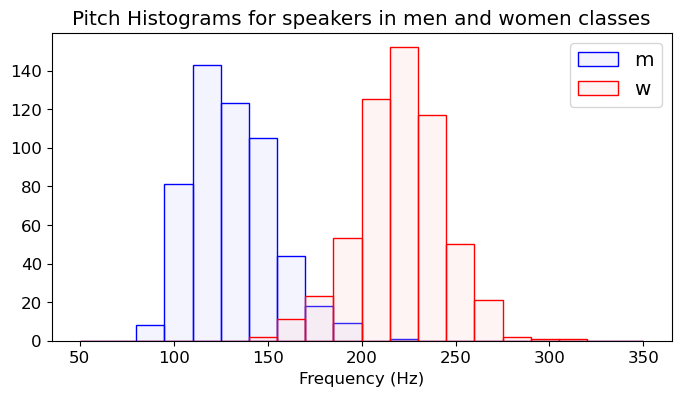

In [5]:
# select 2 gender classes from m(en), w(omen), b(oys), g(irls)
plot_pitch_histogram( ['m','w'] )

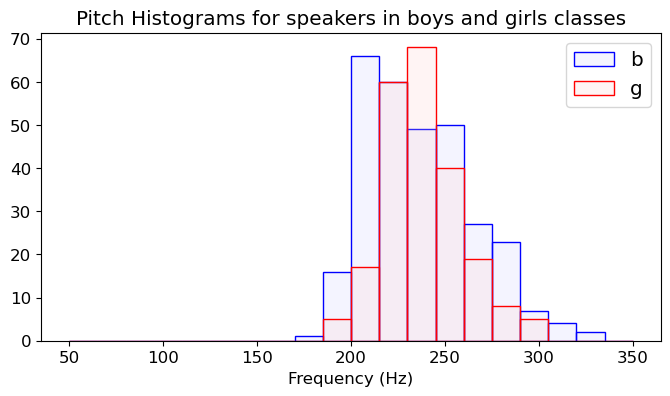

In [6]:
plot_pitch_histogram( ['b','g'] )